In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

### Define data path

In [5]:
rec_folder = r'P:\mouse728449\aw_sal2_2024-04-12_10-16-20\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

No *stim* files were found.
Experiment type: spontaneous


In [17]:
plot_probe = 'probeD'

# make paths
estim_path = exp.stimulus_log_file
probe_info = exp.ephys_params[plot_probe]['probe_info']
ap_raw = exp.ephys_params[plot_probe]['ap_continuous']
ap_time_path = exp.ephys_params[plot_probe]['ap_timestamps']
ap_samples_path = ap_time_path.replace('timestamps_master_clock', 'sample_numbers')
lfp_raw = exp.ephys_params[plot_probe]['lfp_continuous']
lfp_time_path = exp.ephys_params[plot_probe]['lfp_timestamps']
lfp_samples_path = lfp_time_path.replace('timestamps_master_clock', 'sample_numbers')

### Investigate sample numbers for gaps

In [7]:
ap_samples = np.load(ap_samples_path)
lfp_samples = np.load(lfp_samples_path)

In [8]:
print(len(ap_samples))
print(len(lfp_samples))

232508068
19398020


In [9]:
print(ap_samples[:10])
print(ap_samples[-10:])

[1219332 1219333 1219334 1219335 1219336 1219337 1219338 1219339 1219340
 1219341]
[233727390 233727391 233727392 233727393 233727394 233727395 233727396
 233727397 233727398 233727399]


In [10]:
print(lfp_samples[:10])
print(lfp_samples[-10:])

[101611 101612 101613 101614 101615 101616 101617 101618 101619 101620]
[19499621 19499622 19499623 19499624 19499625 19499626 19499627 19499628
 19499629 19499630]


In [11]:
np.where(np.diff(ap_samples) > 1)

(array([], dtype=int64),)

In [12]:
np.where(np.diff(lfp_samples) > 1)

(array([], dtype=int64),)

### Plot some data

In [20]:
plot_type = 'ap'

numCh = 384
if plot_type == 'ap':
    rawDatamm = np.memmap(ap_raw, dtype='int16', mode='r')
    datamm = np.reshape(rawDatamm, (int(rawDatamm.size/numCh), numCh))
    samp_rate = 30000
    timestamps = np.load(ap_time_path)
elif plot_type == 'lfp':
    rawDatamm = np.memmap(lfp_raw, dtype='int16', mode='r')
    datamm = np.reshape(rawDatamm, (int(rawDatamm.size/numCh), numCh))
    samp_rate = 2500
    timestamps = np.load(lfp_time_path)

In [21]:
print(timestamps[:10])
print(timestamps[-10:])

[23.26626715 23.26630048 23.26633381 23.26636715 23.26640048 23.26643381
 23.26646715 23.26650048 23.26653381 23.26656715]
[7773.49863753 7773.49867087 7773.4987042  7773.49873753 7773.49877087
 7773.4988042  7773.49883753 7773.49887087 7773.4989042  7773.49893753]


<IPython.core.display.Javascript object>


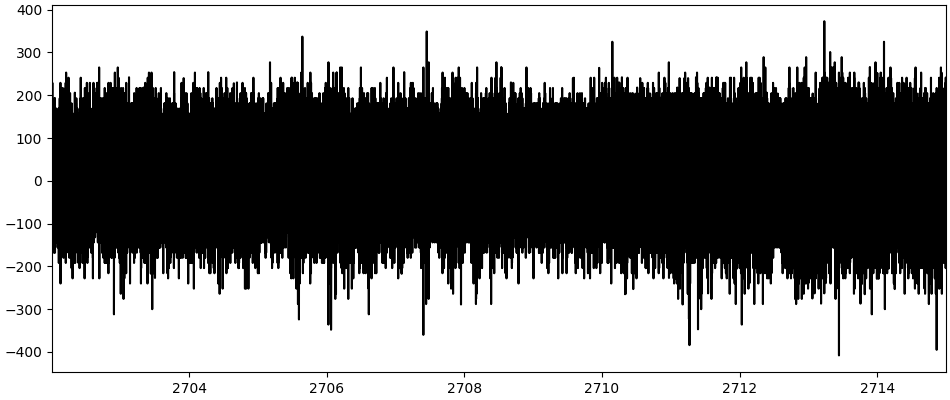

(2702.000028929352, 2714.999976004289)

In [32]:
plotwin = [2702., 2715.]
plotch = 215

pinds = np.nonzero((timestamps > plotwin[0]) & (timestamps < plotwin[1]))[0]

fig, ax = plt.subplots(figsize=(9.5, 4), constrained_layout=True)

ax.plot(timestamps[pinds], datamm[pinds, plotch], 'k')
ax.set_xlim((timestamps[pinds[0]], timestamps[pinds[-1]]))

### Enter parameters for plotting

In [7]:
plot_type = 'ap' # 'ap' or 'lfp'
plot_chunk = 5 # number of channels per plot
plot_before = 5 # time before event, s
plot_after = 5 # time after event, s
plot_event = 'spont' # 'spont' or 'stim'

# if plot_event == 'spont'
spont_time = 50 # time in minutes to plot around if spont is chosen
# if plot_event == 'stim'
event_ind = 2 # stim_event time to choose, must be integer
stim_type = 'biphasic' # 'monophasic' or 'biphasic'
stim_amp = 70 # current amplitude = [20, 50, 70, 100]
stim_sweep = 2 # look at an event during chosen sweep, int between 0 and 9?

### Select data

In [9]:
numCh = 384
if plot_type == 'ap':
    rawDatamm = np.memmap(ap_raw, dtype='int16', mode='r')
    datamm = np.reshape(rawDatamm, (int(rawDatamm.size/numCh), numCh))
    samp_rate = 30000
    timestamps = np.load(ap_time_path)
elif plot_type == 'lfp':
    rawDatamm = np.memmap(lfp_raw, dtype='int16', mode='r')
    datamm = np.reshape(rawDatamm, (int(rawDatamm.size/numCh), numCh))
    samp_rate = 2500
    timestamps = np.load(lfp_time_path)

In [10]:
stim_log = pd.read_csv(estim_path)
stim_log.head()

,stim_type,amplitude,duration,onset,offset,sweep
0,biphasic,70,400.0,130.842280,130.84299,0
1,biphasic,70,400.0,134.439439,134.44025,0
2,biphasic,70,400.0,138.758008,138.75891,0
3,biphasic,70,400.0,143.075967,143.07698,0
4,biphasic,70,400.0,147.298836,147.29994,0


In [11]:
if plot_event == 'spont':
    plot_time = spont_time*60 # this value should be in seconds now
#     time_axis = np.linspace(plot_time-plot_before, plot_time+plot_after, num=5)
elif plot_event == 'stim':
    stim_times = get_stim_events(stim_log, stim_type, stim_amp, stim_sweep)
    plot_time = stim_times[event_ind] # this value should be in seconds
#     time_axis = np.linspace(-plot_before, plot_after, num=6)

In [12]:
# collect data
plot_inds = np.argwhere((timestamps > plot_time-plot_before) & (timestamps < plot_time+plot_after)).flatten()
plot_traces = datamm[plot_inds, :]
time_axis = (timestamps[plot_inds] - plot_time)*1000 # convert timestamps to ms

In [13]:
# want to bring in data from probe_info.json about DC offset, those values need to be *0.195 also in order to convert to uV
with open(probe_info) as data_file:
    data = json.load(data_file)
offset = np.array(data['offset'])

In [14]:
if plot_type == 'lfp':
    plot_traces = plot_traces[:,exp.NPX_lfp_channel_order]
plot_traces = (plot_traces - offset) * 0.195 # removes DC offset and converts bits to uV

### Plot raw data, 50 channels/plot

In [15]:
ch_chunks = np.arange(0, numCh, plot_chunk)

<IPython.core.display.Javascript object>


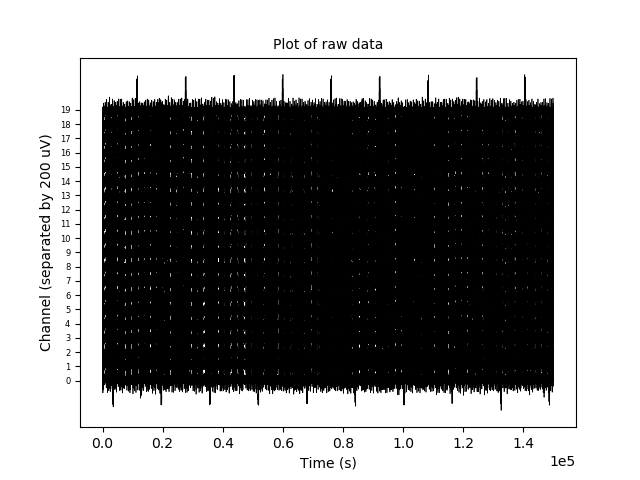

<IPython.core.display.Javascript object>


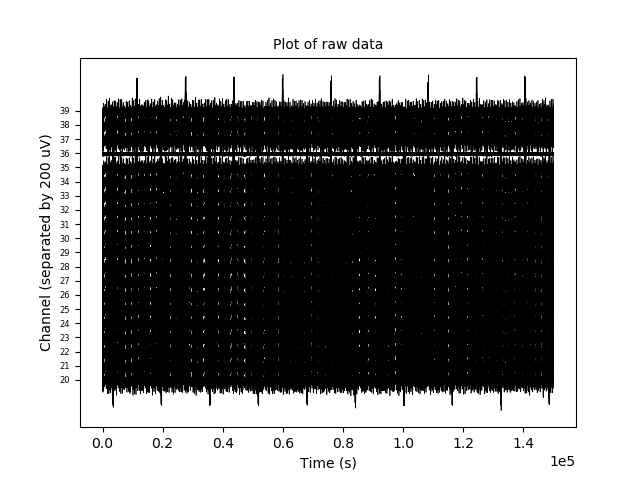

<IPython.core.display.Javascript object>


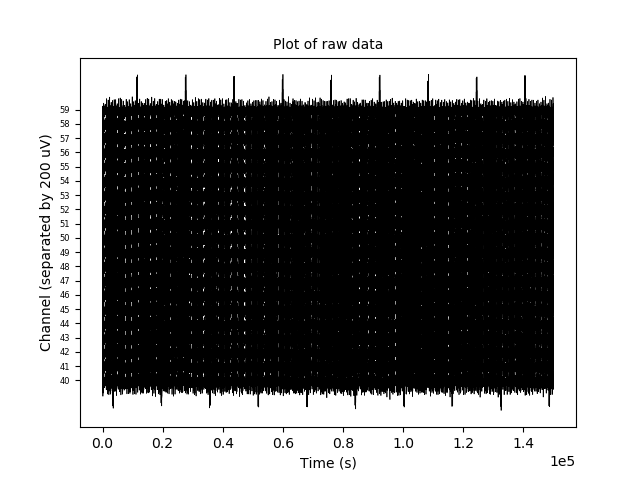

<IPython.core.display.Javascript object>


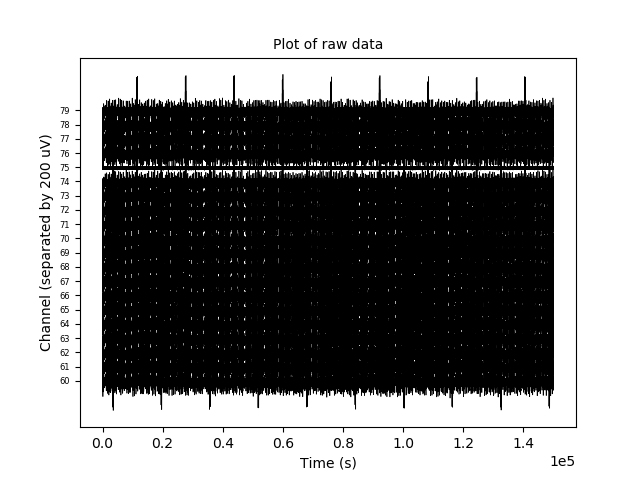

<IPython.core.display.Javascript object>


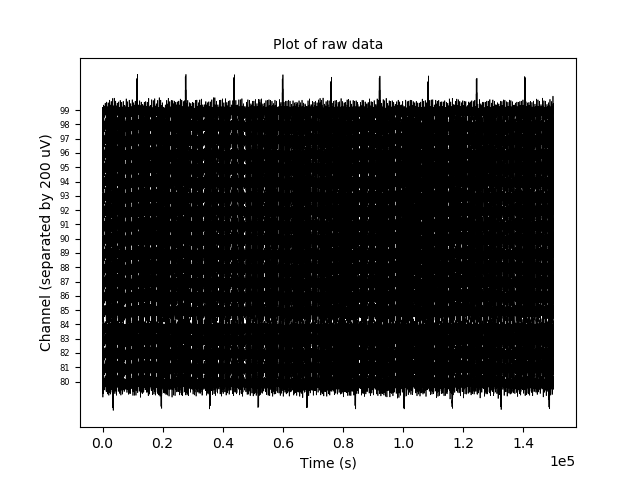

<IPython.core.display.Javascript object>


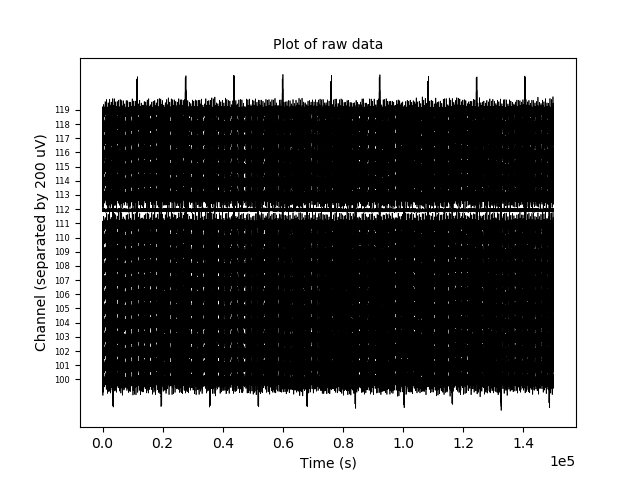

<IPython.core.display.Javascript object>


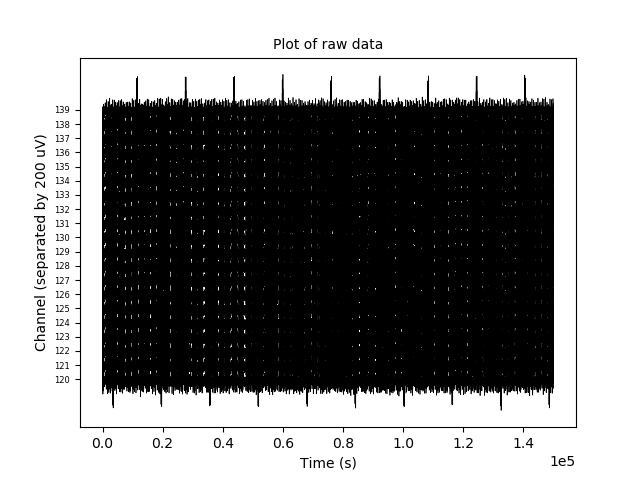

<IPython.core.display.Javascript object>


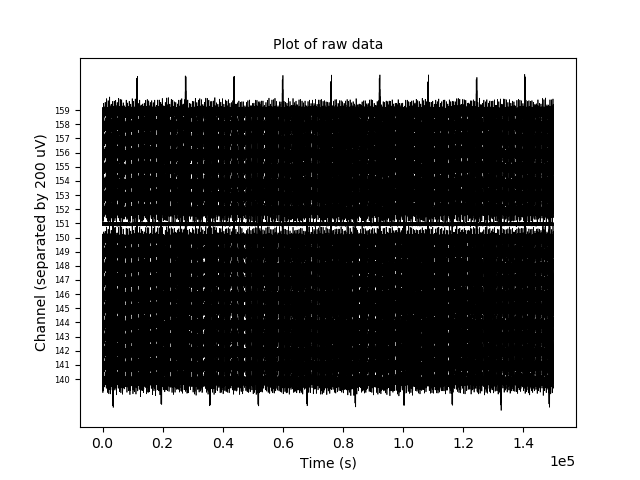

<IPython.core.display.Javascript object>


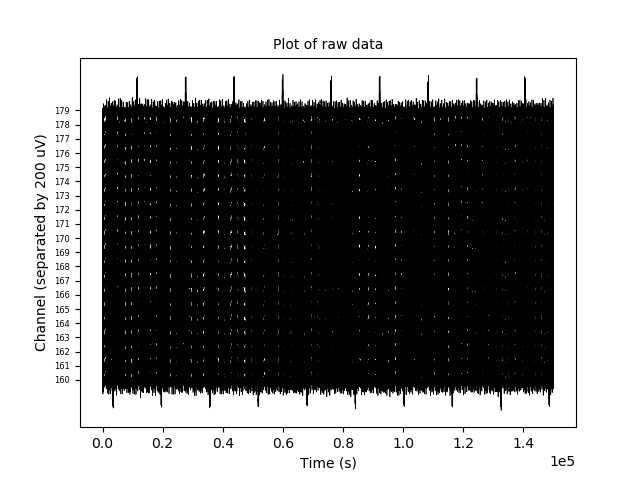

<IPython.core.display.Javascript object>


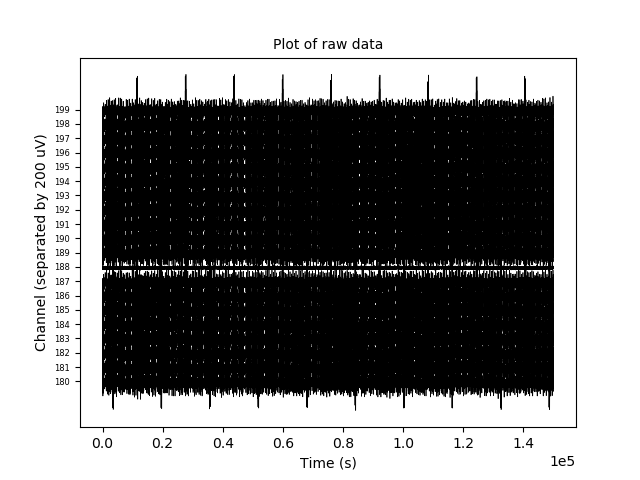

<IPython.core.display.Javascript object>


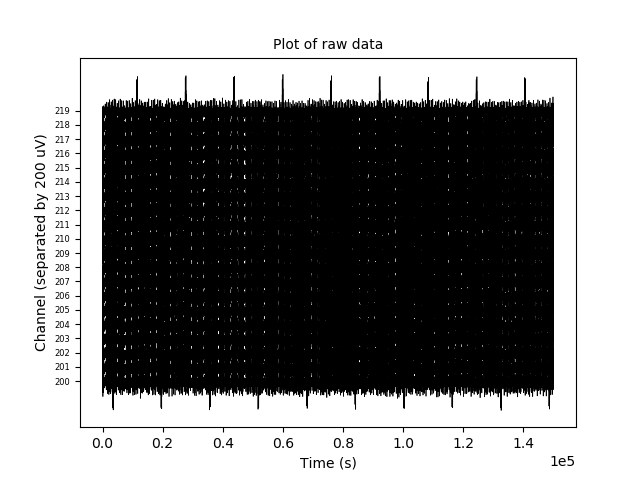

<IPython.core.display.Javascript object>


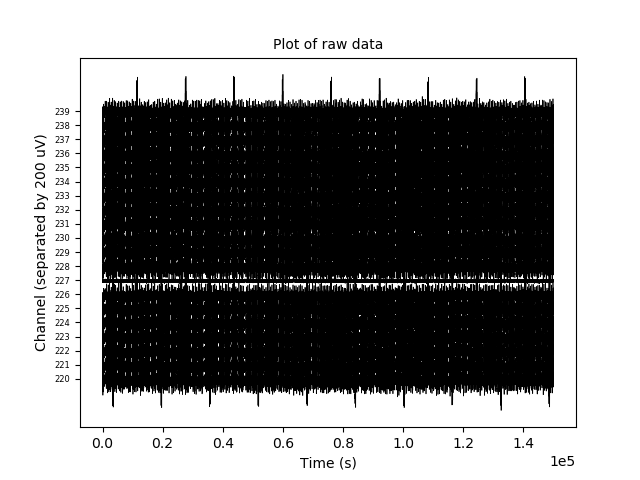

<IPython.core.display.Javascript object>


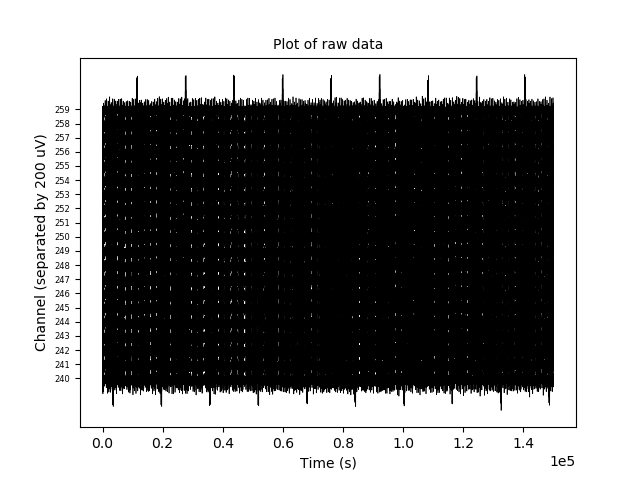

<IPython.core.display.Javascript object>


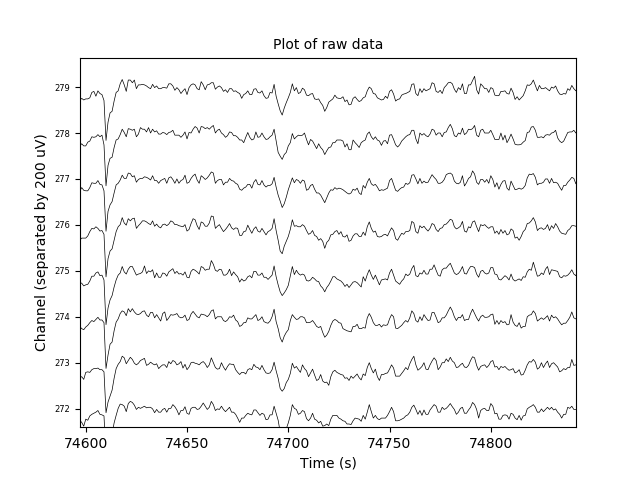

<IPython.core.display.Javascript object>


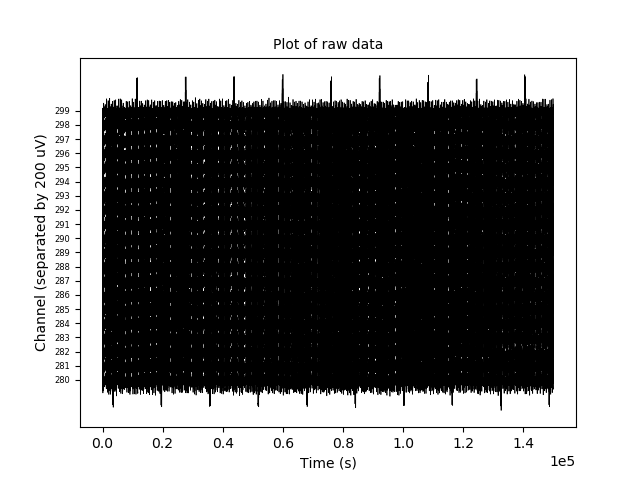

<IPython.core.display.Javascript object>


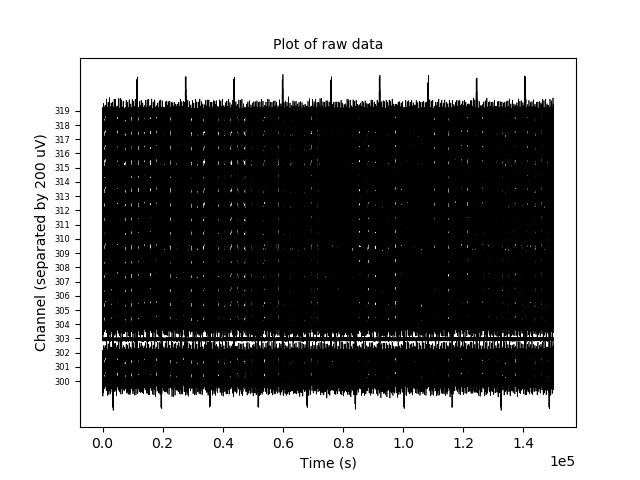

<IPython.core.display.Javascript object>


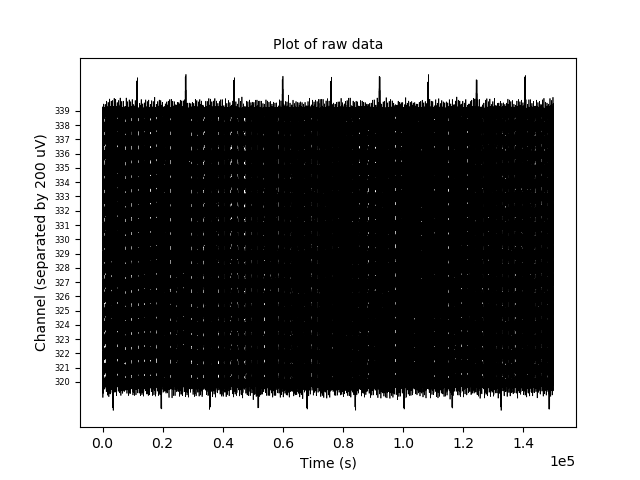

<IPython.core.display.Javascript object>


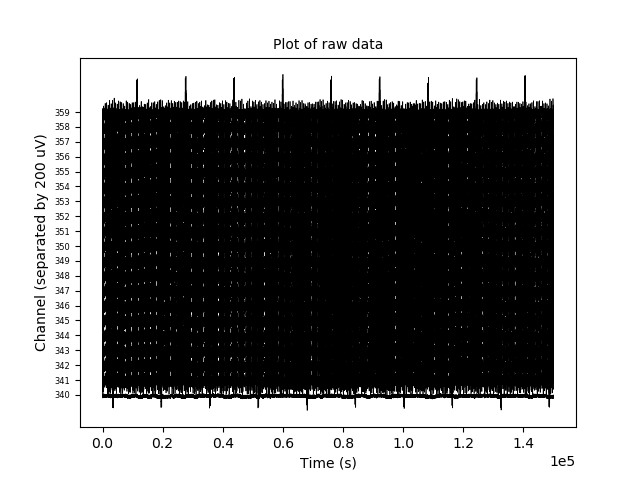

<IPython.core.display.Javascript object>


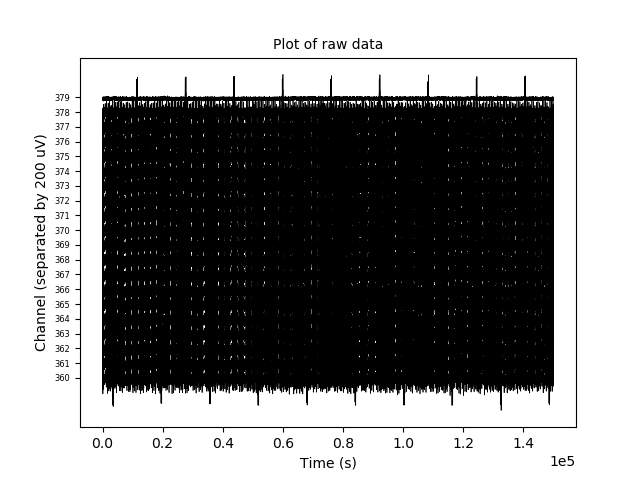

<IPython.core.display.Javascript object>


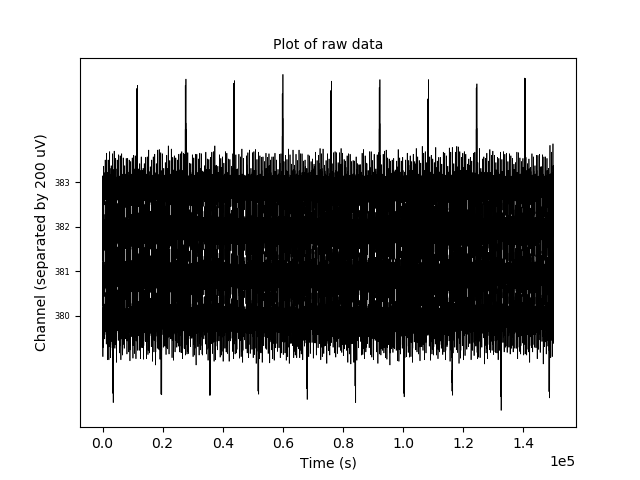

In [16]:
for chx in ch_chunks:
    fig, ax = plt.subplots()
    sep = 0
    if chx+plot_chunk > numCh:
        plot_chunk = numCh - chx
    for chind in range(chx, chx+plot_chunk):
        ax.plot(plot_traces[:,chind]+sep*200, 'k', linewidth=0.5)
        sep += 1

    ax.set(xlabel='Time (s)', ylabel='Channel (separated by 200 uV)', title='Plot of raw data')
#     ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.yticks(range(0, sep*200, 200), range(chx, chx+plot_chunk, 1), fontsize=6)
#     plt.xticks(np.linspace(0, len(plot_traces), num=5), time_axis, fontsize=6)

    plt.show()